In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
import math
import itertools
import matplotlib.pyplot as plt
import tensorflow_probability.python.experimental.substrates.jax as tfp
from IMNN.experimental.jax.imnn import SimulatorIMNN
from IMNN.experimental.jax.imnn import GradientIMNN
from IMNN.experimental.jax.lfi import GaussianApproximation
from IMNN.experimental.jax.lfi import ApproximateBayesianComputation
rng = jax.random.PRNGKey(0)

/Users/tomcharnock/.pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Simulator in JAX

In [3]:
θ_fid = np.array([0., 1.])
n_params = 2
input_shape = (10,)
simulator_args = {"input shape": input_shape}

In [4]:
def simulator(rng, θ, simulator_args=simulator_args):
    μ, Σ = θ
    def fn(key, μ, Σ):
        return μ + np.sqrt(Σ) * jax.random.normal(key, shape=simulator_args["input shape"])
    if μ.shape == Σ.shape:
        if len(μ.shape) == 0:
            return fn(rng, μ, Σ)
        else:
            keys = jax.random.split(rng, num=μ.shape[0]+1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(lambda key, μ, Σ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, μ, Σ)
    else:
        if len(μ.shape) > 0:
            keys = jax.random.split(rng, num=μ.shape[0]+1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(lambda key, μ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, μ)
        elif len(Σ.shape) > 0:
            keys = jax.random.split(rng, num=Σ.shape[0])
            return jax.vmap(lambda key, Σ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, Σ)

In [5]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return jax.jacrev(simulator, argnums=1)(rng, θ, simulator_args=simulator_args)

In [6]:
μs = [np.zeros(()), np.zeros((1,)), np.zeros((2,)), np.zeros((1, 1)), np.zeros((1, 2)), np.zeros((2, 1)), np.zeros((2, 2)), np.zeros((1, 2, 3)), np.zeros((2, 1, 3)), np.zeros((3, 2, 1))] 
Σs = [np.ones(()), np.ones((1,)), np.ones((2,)), np.ones((1, 1)), np.ones((1, 2)), np.ones((2, 1)), np.ones((2, 2)), np.ones((1, 2, 3)), np.ones((2, 1, 3)), np.ones((3, 2, 1))]
for θ in itertools.product(μs[:2], Σs[:2]):
    simulation = simulator(rng, θ, simulator_args=simulator_args)
    print(θ[0].shape, θ[1].shape, simulation.shape)

() () (10,)
() (1,) (1, 10)
(1,) () (1, 10)
(1,) (1,) (1, 10)


# Data for ABC example

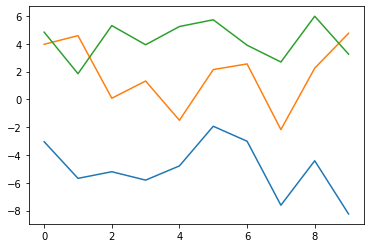

In [7]:
rng, key = jax.random.split(rng)
target_data = simulator(key, (np.array([-5., 2., 4.]), np.array([2., 5., 1.])), simulator_args=simulator_args)
plt.plot(target_data.T);

In [8]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]
        
    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = jax.random.split(key, num=len(self.event_shape))
        return [jax.random.uniform(keys[i], shape=(n,), minval=self.low[i], maxval=self.high[i]) for i in range(len(self.event_shape))]

prior = uniform([-10., 0.], [10., 10.])

# Model in STAX

In [9]:
n_summaries = 5
n_s = 1000
n_d = 1000
λ = 10.
ϵ = 0.1
α = - math.log(ϵ * (λ - 1.) + ϵ**2. / (1 + ϵ)) / ϵ

In [10]:
model = stax.serial(
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(n_summaries))

In [11]:
optimiser = optimizers.adam(step_size=1e-3)

# Random seeds for IMNN

In [12]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

# Random seeds for ABC

In [13]:
rng, abc_key = jax.random.split(rng)

# Simulations on the fly

### Initialise IMNN

In [15]:
simulator_imnn = SimulatorIMNN(n_s=n_s, n_d=n_d, n_summaries=n_summaries, input_shape=input_shape, 
                               θ_fid=θ_fid, key=initial_model_key, model=model, optimiser=optimiser, 
                               simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args))

#### Fit

In [16]:
simulator_imnn.fit(λ=λ, α=α, rng=fitting_key)

no available validation data. setting statistics with training set


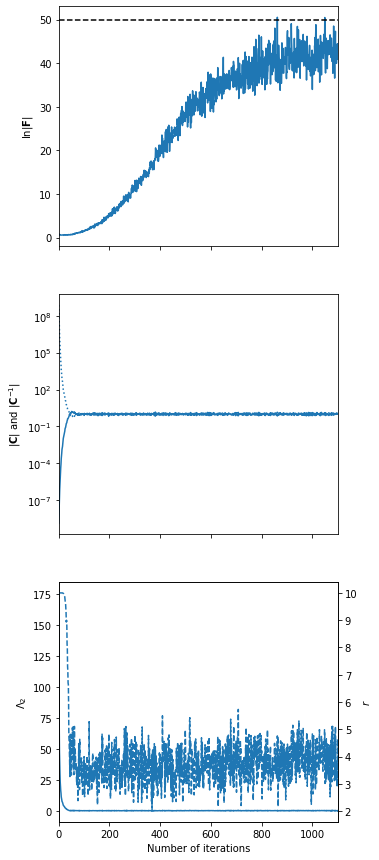

In [17]:
simulator_imnn.training_plot(expected_detF=50);

#### ABC

In [18]:
simulator_target_summaries = simulator_imnn.get_estimate(target_data)

In [19]:
simulator_ga = GaussianApproximation(simulator_target_summaries, simulator_imnn.invC, prior)

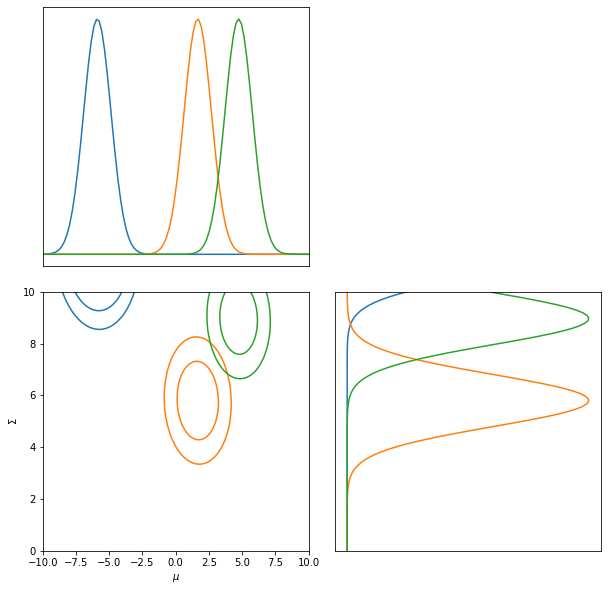

In [20]:
simulator_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"]);

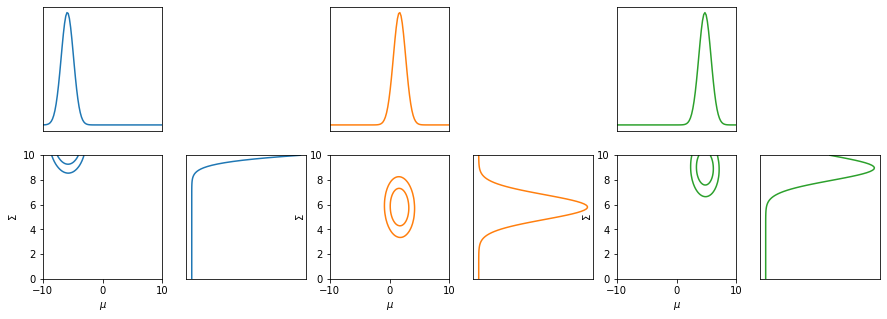

In [21]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
simulator_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
simulator_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
simulator_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);

In [24]:
simulator_abc = ApproximateBayesianComputation(target_data, prior, simulator, simulator_imnn.get_estimate, F=simulator_imnn.F, gridsize=50)

In [25]:
simulator_abc(rng=abc_key, n_samples=int(1e6), min_accepted=1000, max_iterations=1000, ϵ=0.1, smoothing=1);

1008 accepted in last 71 iterations  (71000000 simulations done). 


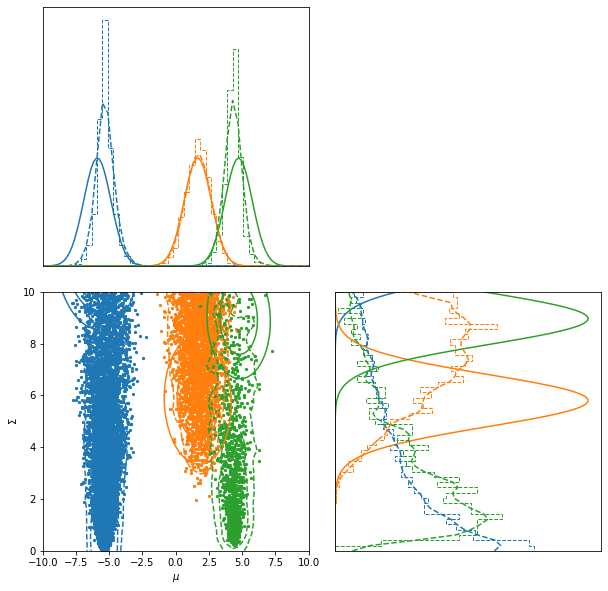

In [26]:
ax = simulator_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"])
simulator_abc.marginal_plot(ax=ax, linestyle="dashed")
simulator_abc.scatter_plot(ax=ax, linestyle="dashed");

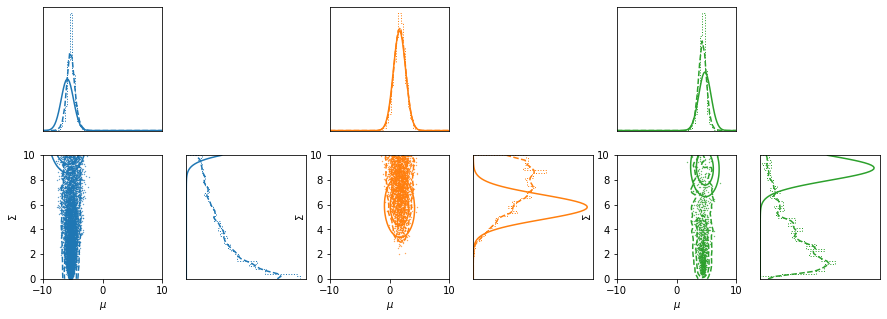

In [27]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
simulator_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
simulator_abc.marginal_plot(ax=ax[:, :2], linestyle="dashed", target=0);
simulator_abc.scatter_plot(ax=ax[:, :2], linestyle="dotted", target=0, s=0.1);
simulator_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
simulator_abc.marginal_plot(ax=ax[:, 2:4], linestyle="dashed", target=1);
simulator_abc.scatter_plot(ax=ax[:, 2:4], linestyle="dotted", target=1, s=0.1);
simulator_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);
simulator_abc.marginal_plot(ax=ax[:, 4:], linestyle="dashed", target=2);
simulator_abc.scatter_plot(ax=ax[:, 4:], linestyle="dotted", target=2, s=0.1);

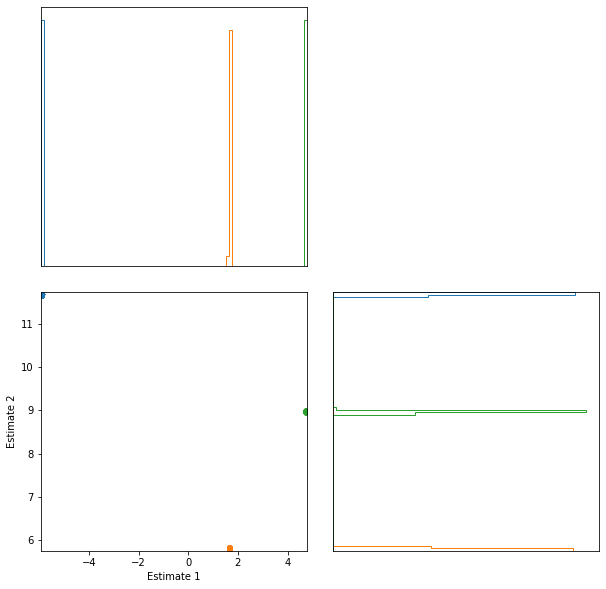

In [28]:
simulator_abc.scatter_summaries(labels=["Estimate 1", "Estimate 2"]);

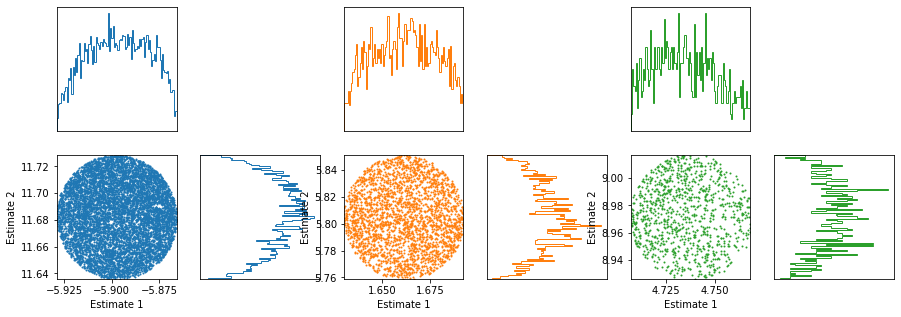

In [29]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
simulator_abc.scatter_summaries(ax=ax[:, :2], labels=["Estimate 1", "Estimate 2"], s=1, target=0, format=True);
simulator_abc.scatter_summaries(ax=ax[:, 2:4], labels=["Estimate 1", "Estimate 2"], s=1, target=1, format=True);
simulator_abc.scatter_summaries(ax=ax[:, 4:], labels=["Estimate 1", "Estimate 2"], s=1, target=2, format=True);

# Precomputed simulations

In [14]:
def get_simulations(rng, n_s, θ, simulator_args=simulator_args):
    def get_simulator(key):
        return simulator(key, θ, simulator_args=simulator_args)
    keys = jax.random.split(rng, num=n_s)
    return jax.vmap(get_simulator)(np.array(keys))

def get_simulation_gradients(rng, n_s, n_d, θ, simulator_args=simulator_args):
    def get_batch_gradient(key):
        return simulator_gradient(key, θ, simulator_args=simulator_args)
    keys = jax.random.split(rng, num=n_s)
    return jax.vmap(get_batch_gradient)(np.array(keys)[:n_d])

In [15]:
rng, training_key = jax.random.split(rng)

In [16]:
fiducial = get_simulations(training_key, n_s, θ_fid, simulator_args=simulator_args)
derivative = get_simulation_gradients(training_key, n_s, n_d, θ_fid, simulator_args=simulator_args)

fiducial.shape, derivative.shape

((1000, 10), (1000, 10, 2))

In [33]:
gradient_no_validation_imnn = GradientIMNN(n_s=n_s, n_d=n_d, n_summaries=n_summaries, input_shape=input_shape, 
                                           θ_fid=θ_fid, key=initial_model_key, model=model, optimiser=optimiser, 
                                           fiducial=fiducial, derivative=derivative)

In [34]:
gradient_no_validation_imnn.fit(λ=λ, α=α, rng=fitting_key)

no available validation data. setting statistics with training set


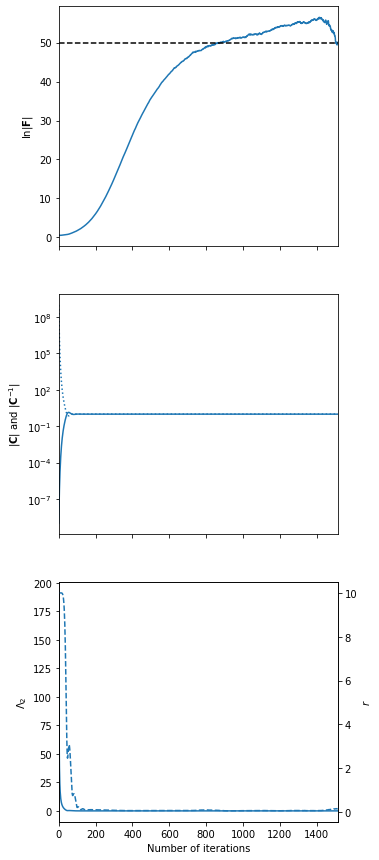

In [35]:
gradient_no_validation_imnn.training_plot(expected_detF=50);

#### ABC

In [36]:
gradient_no_validation_target_summaries = gradient_no_validation_imnn.get_estimate(target_data)

In [37]:
gradient_no_validation_ga = GaussianApproximation(gradient_no_validation_target_summaries, gradient_no_validation_imnn.invC, prior)

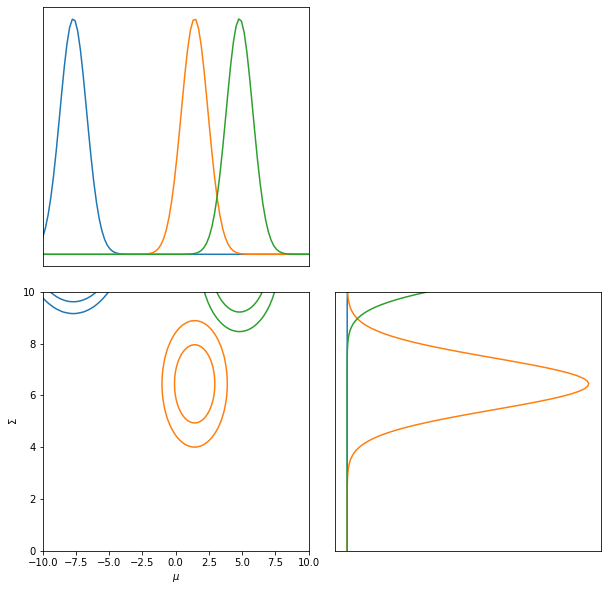

In [38]:
gradient_no_validation_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"]);

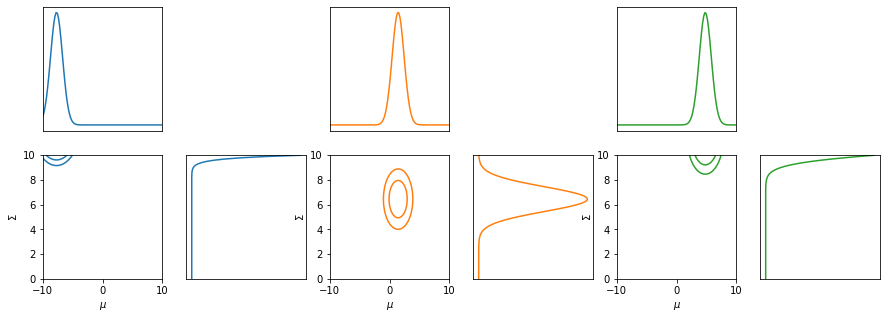

In [39]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
gradient_no_validation_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
gradient_no_validation_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
gradient_no_validation_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);

In [40]:
gradient_no_validation_abc = ApproximateBayesianComputation(target_data, prior, simulator, gradient_no_validation_imnn.get_estimate, F=gradient_no_validation_imnn.F, gridsize=50)

In [41]:
gradient_no_validation_abc(rng=abc_key, n_samples=int(1e6), min_accepted=1000, max_iterations=1000, ϵ=0.1, smoothing=1);

1021 accepted in last 35 iterations  (35000000 simulations done). 


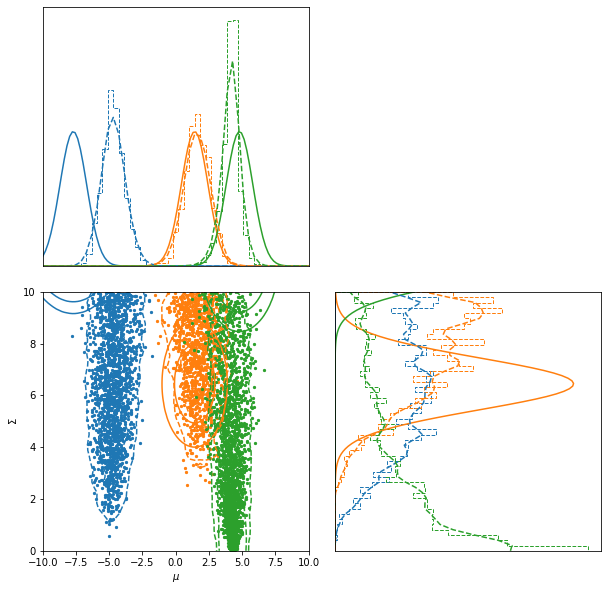

In [42]:
ax = gradient_no_validation_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"])
gradient_no_validation_abc.marginal_plot(ax=ax, linestyle="dashed")
gradient_no_validation_abc.scatter_plot(ax=ax, linestyle="dashed");

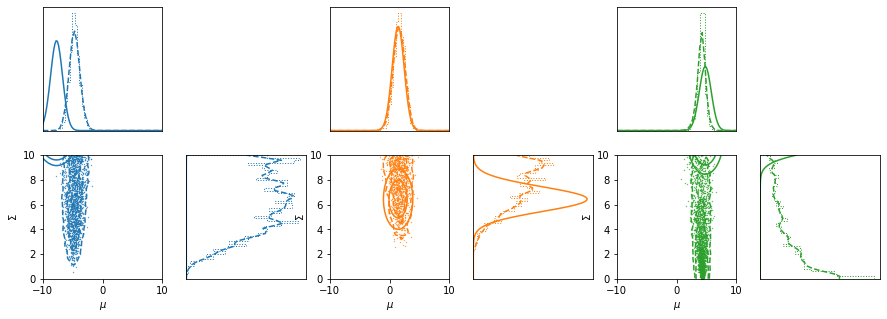

In [43]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
gradient_no_validation_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
gradient_no_validation_abc.marginal_plot(ax=ax[:, :2], linestyle="dashed", target=0);
gradient_no_validation_abc.scatter_plot(ax=ax[:, :2], linestyle="dotted", target=0, s=0.1);
gradient_no_validation_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
gradient_no_validation_abc.marginal_plot(ax=ax[:, 2:4], linestyle="dashed", target=1);
gradient_no_validation_abc.scatter_plot(ax=ax[:, 2:4], linestyle="dotted", target=1, s=0.1);
gradient_no_validation_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);
gradient_no_validation_abc.marginal_plot(ax=ax[:, 4:], linestyle="dashed", target=2);
gradient_no_validation_abc.scatter_plot(ax=ax[:, 4:], linestyle="dotted", target=2, s=0.1);

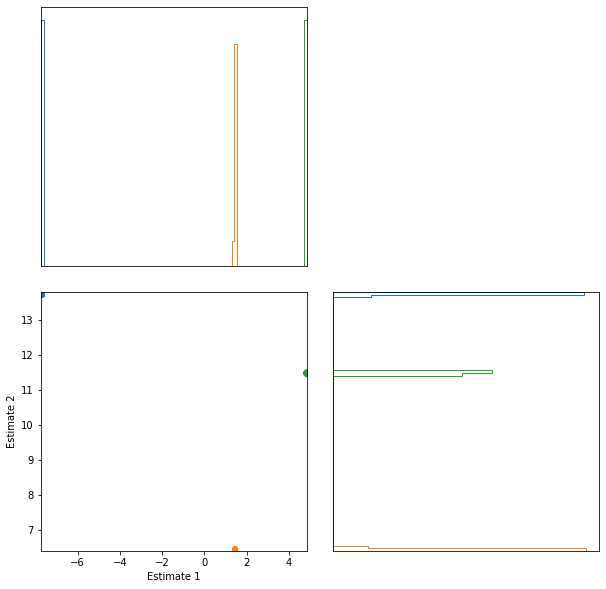

In [44]:
gradient_no_validation_abc.scatter_summaries(labels=["Estimate 1", "Estimate 2"]);

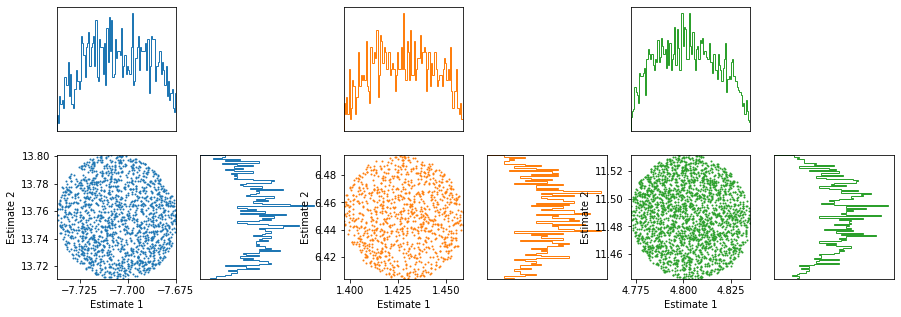

In [45]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
gradient_no_validation_abc.scatter_summaries(ax=ax[:, :2], labels=["Estimate 1", "Estimate 2"], s=1, target=0, format=True);
gradient_no_validation_abc.scatter_summaries(ax=ax[:, 2:4], labels=["Estimate 1", "Estimate 2"], s=1, target=1, format=True);
gradient_no_validation_abc.scatter_summaries(ax=ax[:, 4:], labels=["Estimate 1", "Estimate 2"], s=1, target=2, format=True);

### With validation

In [17]:
rng, validation_key = jax.random.split(rng)

In [18]:
validation_fiducial = get_simulations(validation_key, n_s, θ_fid, simulator_args=simulator_args)
validation_derivative = get_simulation_gradients(validation_key, n_s, n_d, θ_fid, simulator_args=simulator_args)

validation_fiducial.shape, validation_derivative.shape

((1000, 10), (1000, 10, 2))

In [19]:
gradient_imnn = GradientIMNN(n_s=n_s, n_d=n_d, n_summaries=n_summaries, input_shape=input_shape, 
                             θ_fid=θ_fid, key=initial_model_key, model=model, optimiser=optimiser, 
                             fiducial=fiducial, derivative=derivative,
                             validation_fiducial=validation_fiducial,
                             validation_derivative=validation_derivative)

In [20]:
gradient_imnn.fit(λ=λ, α=α, rng=fitting_key)

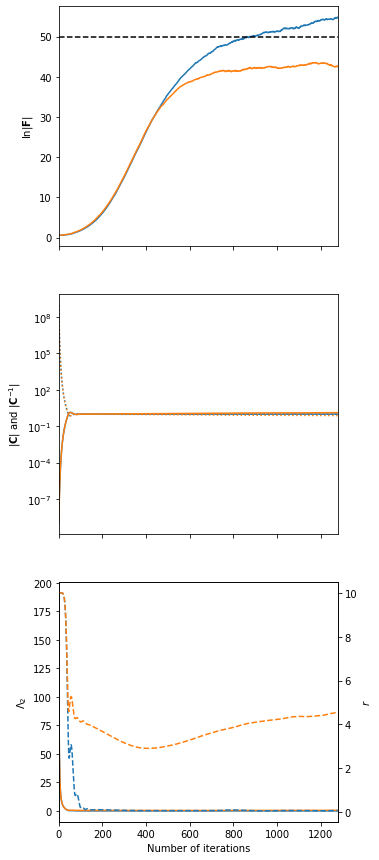

In [21]:
gradient_imnn.training_plot(expected_detF=50);

#### ABC

In [22]:
gradient_target_summaries = gradient_imnn.get_estimate(target_data)

In [23]:
gradient_ga = GaussianApproximation(gradient_target_summaries, gradient_imnn.invC, prior)

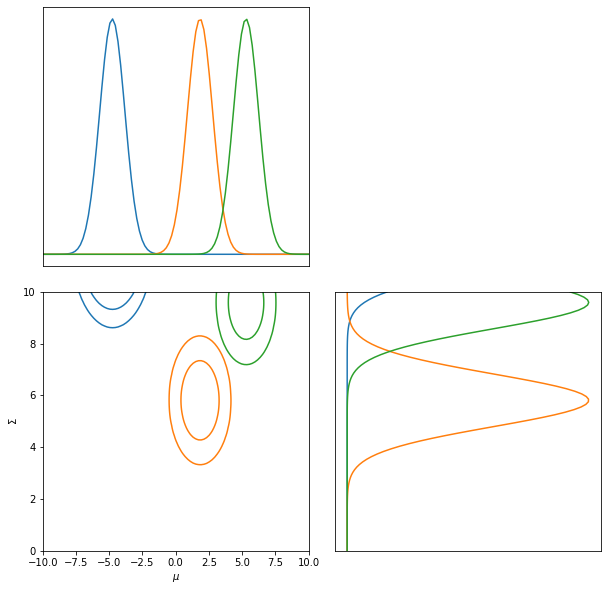

In [24]:
gradient_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"]);

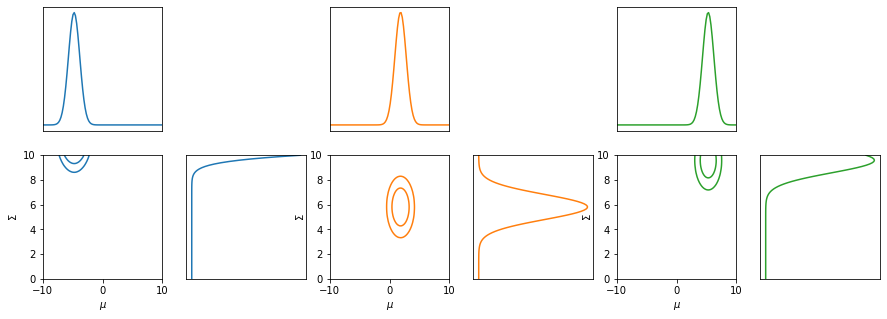

In [25]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
gradient_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
gradient_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
gradient_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);

In [26]:
gradient_abc = ApproximateBayesianComputation(target_data, prior, simulator, gradient_imnn.get_estimate, F=gradient_imnn.F, gridsize=50)

In [27]:
gradient_abc(rng=abc_key, n_samples=int(1e6), min_accepted=1000, max_iterations=1000, ϵ=0.1, smoothing=1);

1021 accepted in last 34 iterations  (34000000 simulations done). 


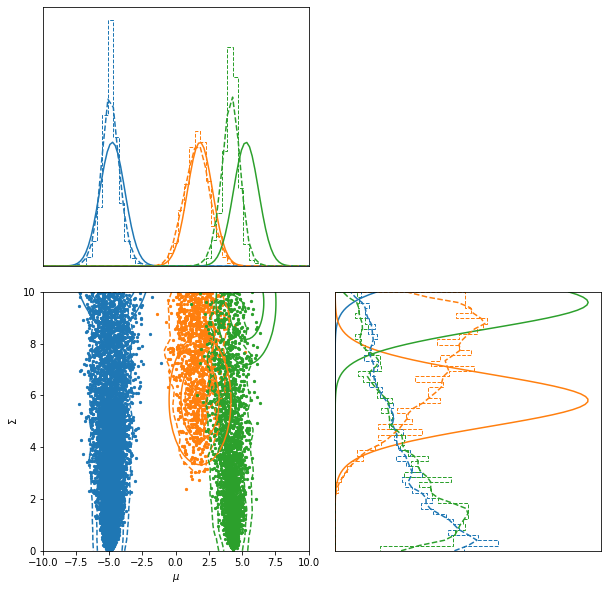

In [28]:
ax = gradient_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"])
gradient_abc.marginal_plot(ax=ax, linestyle="dashed")
gradient_abc.scatter_plot(ax=ax, linestyle="dashed");

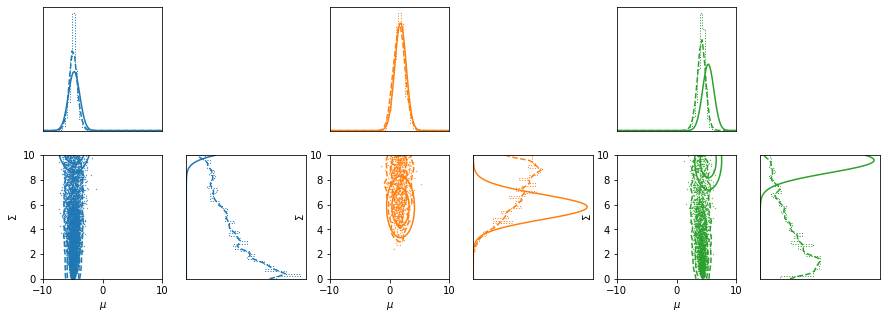

In [29]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
gradient_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
gradient_abc.marginal_plot(ax=ax[:, :2], linestyle="dashed", target=0);
gradient_abc.scatter_plot(ax=ax[:, :2], linestyle="dotted", target=0, s=0.1);
gradient_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
gradient_abc.marginal_plot(ax=ax[:, 2:4], linestyle="dashed", target=1);
gradient_abc.scatter_plot(ax=ax[:, 2:4], linestyle="dotted", target=1, s=0.1);
gradient_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);
gradient_abc.marginal_plot(ax=ax[:, 4:], linestyle="dashed", target=2);
gradient_abc.scatter_plot(ax=ax[:, 4:], linestyle="dotted", target=2, s=0.1);

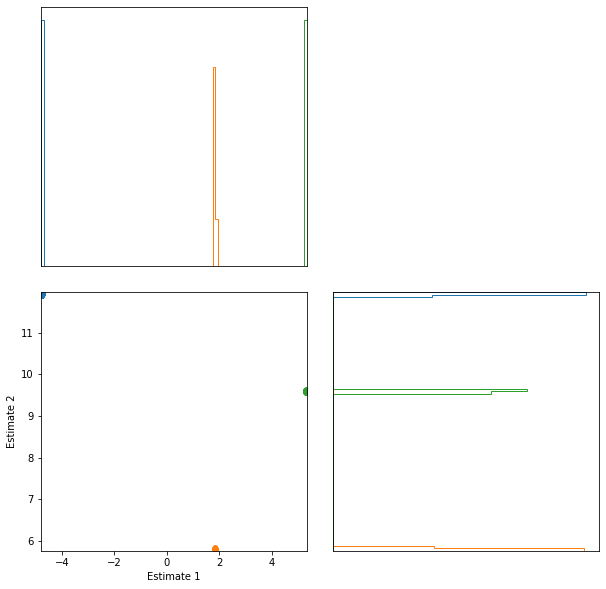

In [30]:
gradient_abc.scatter_summaries(labels=["Estimate 1", "Estimate 2"]);

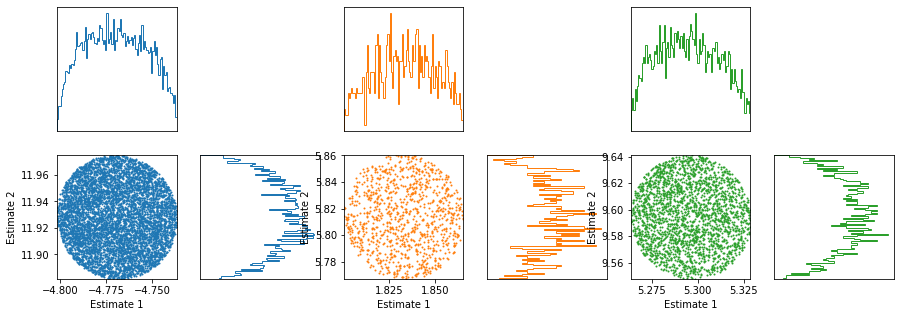

In [31]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
gradient_abc.scatter_summaries(ax=ax[:, :2], labels=["Estimate 1", "Estimate 2"], s=1, target=0, format=True);
gradient_abc.scatter_summaries(ax=ax[:, 2:4], labels=["Estimate 1", "Estimate 2"], s=1, target=1, format=True);
gradient_abc.scatter_summaries(ax=ax[:, 4:], labels=["Estimate 1", "Estimate 2"], s=1, target=2, format=True);